# classification es el notebook oficial de clasificación

### - Limpiamos los datos según conclusiones del notebook main
### - Probaremos distintos algorítmos de clasificación y compararemos los resultados
### - Utilizamos el dataset de train ya recortado por la cátedra (igual creamos un test para pruebas internas)

---





## ACA TODOS LOS IMPORTS DEL NOTEBOOK

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict, StratifiedShuffleSplit
from sklearn.feature_selection import RFECV
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score,accuracy_score,recall_score, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, auc, roc_auc_score, roc_curve, RocCurveDisplay, PrecisionRecallDisplay, plot_precision_recall_curve, plot_roc_curve 

## LECTURA Y LIMPIEZA DEL DATASET

In [37]:
df_orig = pd.read_csv(r"DS_G3_HeartFailure_FULL_train.csv",index_col=0)

In [38]:
df_cleaned = df_orig.copy()
feat_train, feat_test, targ_train, targ_test = train_test_split(df_cleaned.drop(["DEATH_EVENT"],axis=1),df_cleaned["DEATH_EVENT"],test_size=0.2,random_state=420)

In [4]:
rfe = RFECV(RandomForestClassifier(n_estimators=2000),scoring="recall",min_features_to_select=5,cv=10,verbose=1,n_jobs=-1)
rfe = rfe.fit(feat_train,targ_train)

Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.


In [5]:
for feat in zip(feat_train.columns,rfe.support_):
    print(feat)

('age', True)
('anaemia', False)
('creatinine_phosphokinase', True)
('diabetes', False)
('ejection_fraction', True)
('high_blood_pressure', False)
('platelets', False)
('serum_creatinine', True)
('serum_sodium', False)
('sex', False)
('smoking', False)
('time', True)


## Transformaciones necesarias al df

In [39]:
#df_orig["cant_path"] = df_orig["anaemia"]+df_orig["high_blood_pressure"]+df_orig["diabetes"]
#df_cleaned = df_orig.copy()
df_cleaned = df_orig.drop(["time","anaemia","diabetes","high_blood_pressure","sex","smoking"],axis=1)
#df_cleaned = df_orig.drop(["anaemia","diabetes","high_blood_pressure","sex","smoking"],axis=1)
# NOS QUEDAMOS CON AGE, EJECTION_FRACTION, SERUM_CREATININE, SERUM_SODIUM Y DEATH_EVENT

In [43]:
df_cleaned.head()

,age,creatinine_phosphokinase,ejection_fraction,platelets,serum_creatinine,serum_sodium,DEATH_EVENT
55,95.0,371,30,461000.0,2.0,132,1
180,40.0,478,30,303000.0,0.9,136,0
237,70.0,232,30,173000.0,1.2,132,0
280,70.0,2695,40,241000.0,1.0,137,0
181,59.0,176,25,221000.0,1.0,136,1


In [44]:
feat_train, feat_test, targ_train, targ_test = train_test_split(df_cleaned.drop(["DEATH_EVENT"],axis=1),df_cleaned["DEATH_EVENT"],test_size=0.2,random_state=420)
#HAY QUE SEPARAR EL TEST ANTES DE ESTANDARIZAR PARA QUE NO INFLUYAN LOS FEATURES DE TEST EN LA MEDIA Y VARIANZA

In [45]:
scaler = StandardScaler()
feat_train = scaler.fit_transform(feat_train)
#APLICAMOS SMOTE PARA AUMENTAR LA CANTIDAD DE SAMPLES Y BALANCEAR EL TARGET
feat_train, targ_train = SMOTE().fit_resample(feat_train, targ_train)

## ACA TENEMOS EL DATASET RECORTADO Y STANDARIZADO 

In [46]:
score_metric = "recall" # Queremos pocos FN, es decir pacientes q decimos q NO tienen riesgo pero SI.

---

## ALGUNAS FUNCIONES UTILES PARA GRAFICAR

In [47]:
def aoc_curves (model,feat,targ):
    predicted_p = cross_val_predict(model,feat,targ,cv=10,method="predict_proba")
    fpr, tpr, thres = roc_curve(targ, predicted_p[:,1])
    precisions, recalls, thres = precision_recall_curve(targ, predicted_p[:,1])
    roc_auc = auc(fpr, tpr)
    pr_auc = auc(recalls, precisions)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    plt.subplot(1,2,1)
    plt.plot(fpr,tpr,label = "ROC AOC:{:.3f}".format(roc_auc))
    plt.plot([0,1],[0,1],'--k', alpha=0.5)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Curva ROC')
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(recalls,precisions,label = "PR AOC:{:.3f}".format(pr_auc))
    plt.plot([1,0],[0,1],'--k', alpha=0.5)
    plt.ylabel('Precisión')
    plt.xlabel('Recall')
    plt.title('Curva PR')
    plt.legend()

---
---
---

# LOGISTIC REGRESSION - Baseline

In [61]:
lr_model = LogisticRegression(fit_intercept=False, dual=False, max_iter=30000)
lr_model.fit(feat_train,targ_train)
lr_predicted = cross_val_predict(lr_model,feat_train,targ_train,cv=10)
lr_predicted_t = lr_model.predict(scaler.transform(feat_test))
print(classification_report(targ_train, lr_predicted))
print(classification_report(targ_test, lr_predicted_t))


              precision    recall  f1-score   support

           0       0.78      0.67      0.72       134
           1       0.71      0.81      0.76       134

    accuracy                           0.74       268
   macro avg       0.75      0.74      0.74       268
weighted avg       0.75      0.74      0.74       268

              precision    recall  f1-score   support

           0       0.81      0.76      0.79        29
           1       0.67      0.74      0.70        19

    accuracy                           0.75        48
   macro avg       0.74      0.75      0.74        48
weighted avg       0.76      0.75      0.75        48



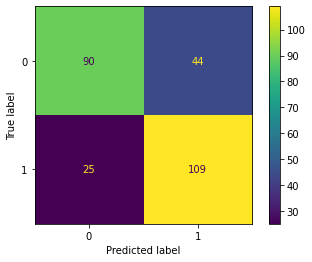

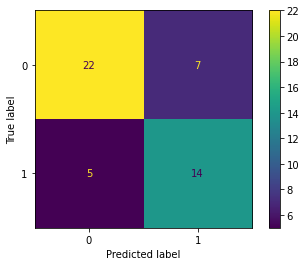

In [62]:
cm = confusion_matrix(targ_train, lr_predicted)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
cm = confusion_matrix(targ_test, lr_predicted_t)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

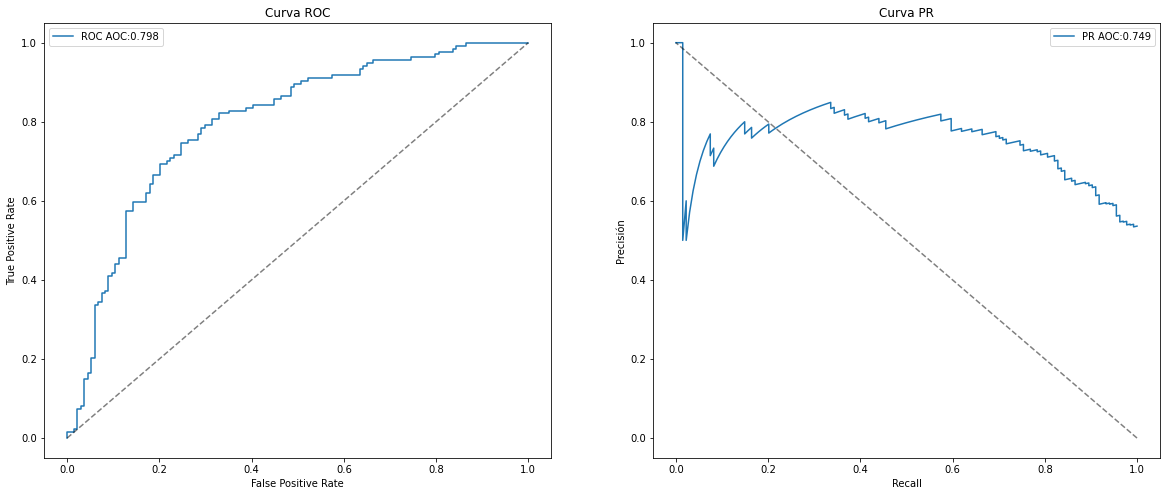

In [63]:
aoc_curves(lr_model,feat_train,targ_train)

---

# SVM

In [163]:
hyperparam = {"C":np.logspace(-2,0,30),"gamma":np.logspace(-2,-0.5,20)}
svm_model = SVC(break_ties=True,probability=True)
svm_grilla = GridSearchCV(svm_model,hyperparam,cv=10,scoring=score_metric,n_jobs=-1)
svm_grilla.fit(feat_train,targ_train)
print(svm_grilla.best_params_)
svm_model = svm_grilla.best_estimator_

{'C': 0.5298316906283708, 'gamma': 0.31622776601683794}


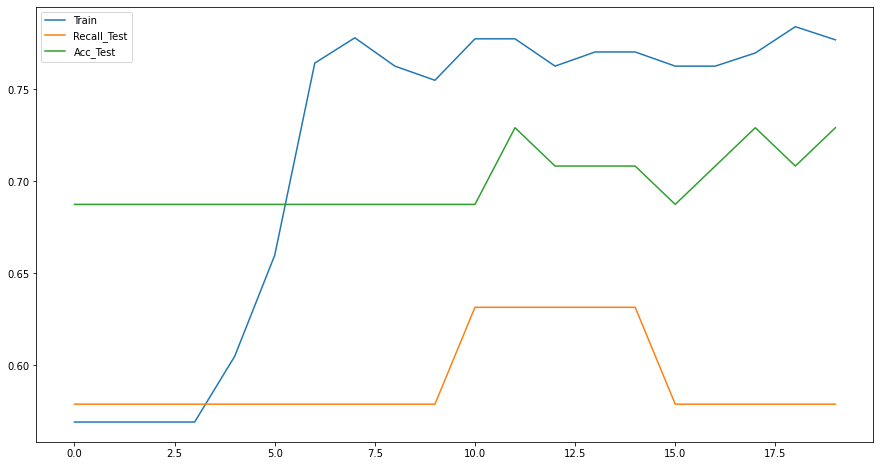

In [162]:
scorings,scorings_t,scorings_acc = [],[],[]
for c in np.logspace(-2,0,20):
    svm_model = SVC(break_ties=True,probability=True,C=c,gamma=0.1)
    svm_model.fit(feat_train,targ_train)
    scorings.append(cross_val_score(svm_model,feat_train,targ_train,cv=10,scoring="recall").mean())
    scorings_t.append(recall_score(targ_test,svm_model.predict(scaler.transform(feat_test))))
    scorings_acc.append(accuracy_score(targ_test,svm_model.predict(scaler.transform(feat_test))))
plt.figure(figsize=(15,8))
plt.plot(scorings,label="Train")
plt.plot(scorings_t,label="Recall_Test")
plt.plot(scorings_acc,label="Acc_Test")
plt.legend()

In [164]:
svm_predicted = cross_val_predict(svm_model,feat_train,targ_train,cv=10)
svm_predicted_t = svm_model.predict(scaler.transform(feat_test))
print(classification_report(targ_train, svm_predicted))
print(classification_report(targ_test, svm_predicted_t))

              precision    recall  f1-score   support

           0       0.79      0.72      0.75       134
           1       0.74      0.81      0.77       134

    accuracy                           0.76       268
   macro avg       0.77      0.76      0.76       268
weighted avg       0.77      0.76      0.76       268

              precision    recall  f1-score   support

           0       0.78      0.86      0.82        29
           1       0.75      0.63      0.69        19

    accuracy                           0.77        48
   macro avg       0.77      0.75      0.75        48
weighted avg       0.77      0.77      0.77        48



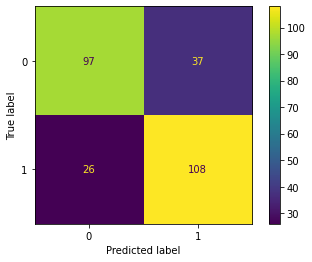

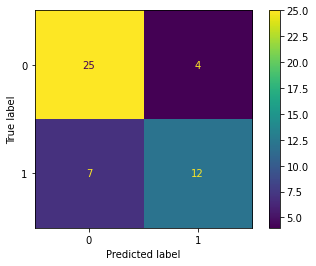

In [165]:
cm = confusion_matrix(targ_train, svm_predicted)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
cm = confusion_matrix(targ_test, svm_predicted_t)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

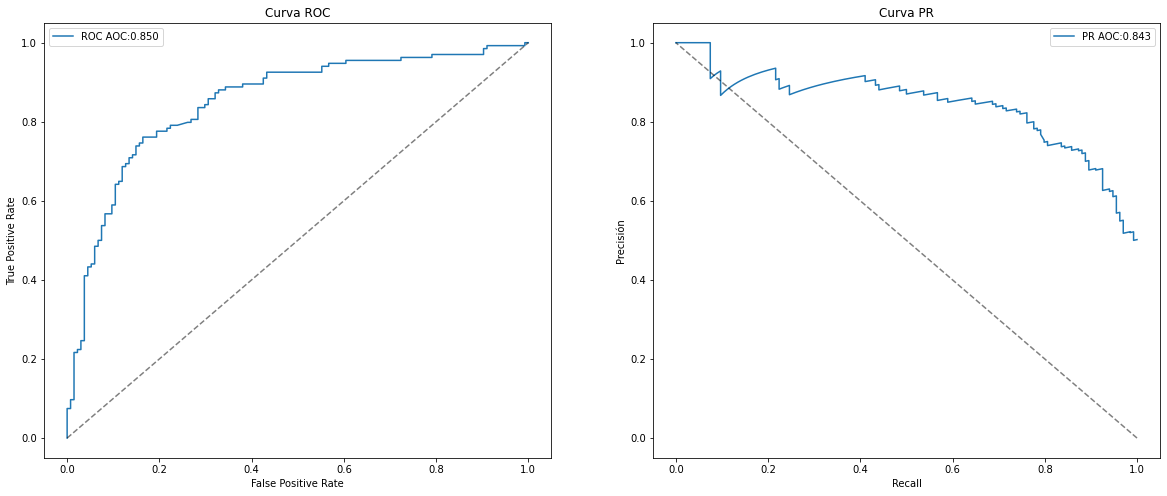

In [166]:
aoc_curves(svm_model,feat_train,targ_train)

---

# Random Forest

In [213]:
hyperparam = {"n_estimators":[40],"max_depth":[6],"min_samples_split":[40]}
rf_model = RandomForestClassifier()
rf_grilla = GridSearchCV(rf_model,hyperparam,cv=10,scoring=score_metric,n_jobs=-1)
rf_grilla.fit(feat_train,targ_train)
rf_model = rf_grilla.best_estimator_
print(rf_grilla.best_params_)

{'max_depth': 6, 'min_samples_split': 40, 'n_estimators': 40}


              precision    recall  f1-score   support

           0       0.81      0.78      0.79       134
           1       0.79      0.82      0.80       134

    accuracy                           0.80       268
   macro avg       0.80      0.80      0.80       268
weighted avg       0.80      0.80      0.80       268

              precision    recall  f1-score   support

           0       0.78      0.86      0.82        29
           1       0.75      0.63      0.69        19

    accuracy                           0.77        48
   macro avg       0.77      0.75      0.75        48
weighted avg       0.77      0.77      0.77        48



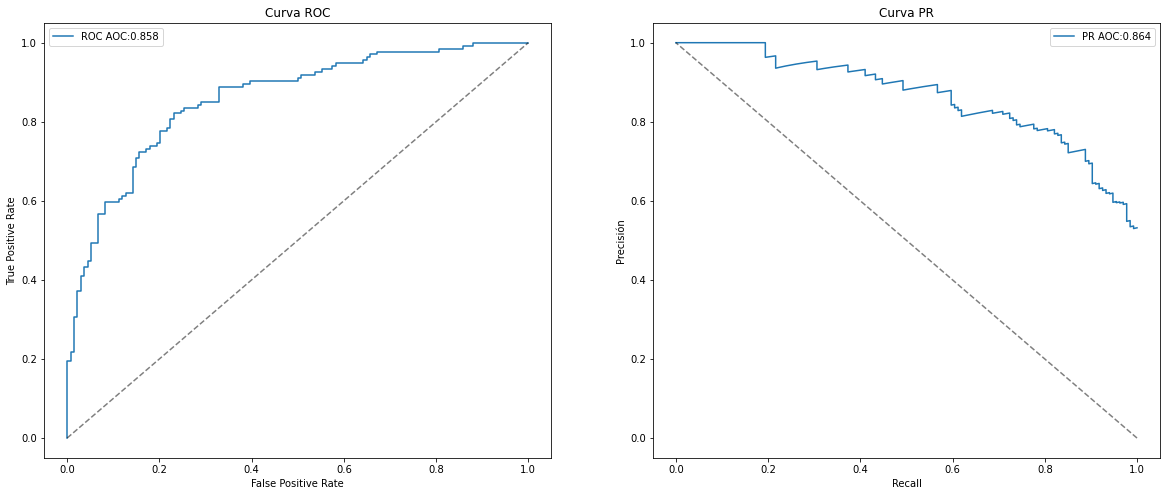

In [214]:
rf_predicted = cross_val_predict(rf_model,feat_train,targ_train,cv=10)
rf_predicted_t = rf_model.predict(scaler.transform(feat_test))
print(classification_report(targ_train, rf_predicted))
print(classification_report(targ_test, rf_predicted_t))
aoc_curves(rf_model,feat_train,targ_train)

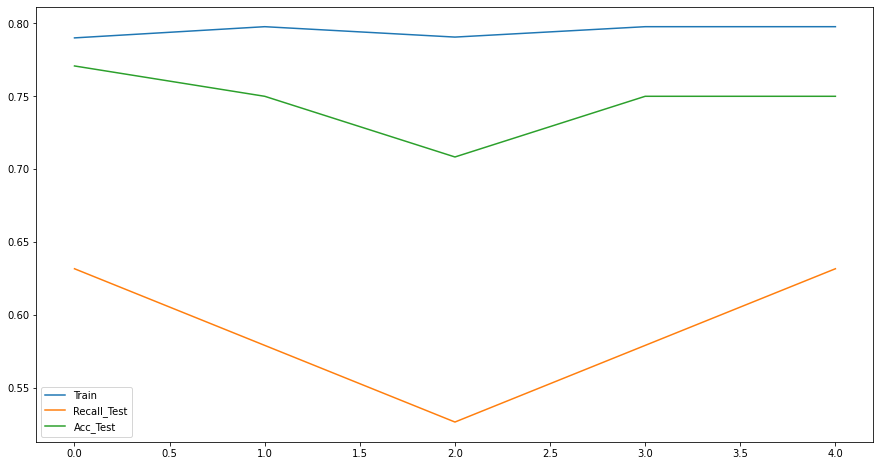

In [188]:
scorings,scorings_t,scorings_acc = [],[],[]
for c in [4,5,10,20,50]:
    rf_model = RandomForestClassifier(max_depth=5,n_estimators=200,min_samples_split=40)
    rf_model.fit(feat_train,targ_train)
    scorings.append(cross_val_score(rf_model,feat_train,targ_train,cv=10,scoring="recall").mean())
    scorings_t.append(recall_score(targ_test,rf_model.predict(scaler.transform(feat_test))))
    scorings_acc.append(accuracy_score(targ_test,rf_model.predict(scaler.transform(feat_test))))
plt.figure(figsize=(15,8))
plt.plot(scorings,label="Train")
plt.plot(scorings_t,label="Recall_Test")
plt.plot(scorings_acc,label="Acc_Test")
plt.legend()

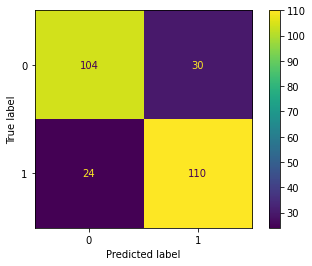

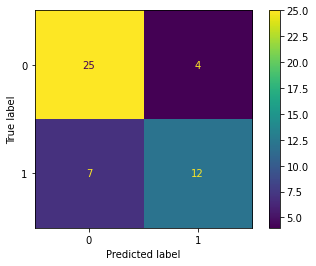

In [215]:
cm = confusion_matrix(targ_train, rf_predicted)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
cm = confusion_matrix(targ_test, rf_predicted_t)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()


---


# GRADIENT BOOSTING